In [1]:
'''import zipfile
with zipfile.ZipFile('sneaker_image_data_cropped.zip', 'r') as zip_ref:
    zip_ref.extractall('sneaker_image_data_cropped')'''

"import zipfile\nwith zipfile.ZipFile('sneaker_image_data_cropped.zip', 'r') as zip_ref:\n    zip_ref.extractall('sneaker_image_data_cropped')"

In [2]:
# check my GPU

!nvidia-smi

Sun Sep 13 04:27:33 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   54C    P0    36W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
import pandas as pd
from custom_loader import ShoeDataset
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from helper import loader_show_image, model_sample_output
from training import train_net
import torch
from torchvision import models
from tqdm.auto import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import OrderedDict

In [4]:
batch_size = 64 #batch size beyond 64 may result in GPU out of memory
train_csv_file = 'train_clean.csv' # csv file containing training image names and corresponding prices
test_csv_file = 'test_clean.csv'
root_dir = 'sneaker_images_clean/' # location of images

train_transform = transforms.Compose([transforms.RandomRotation(20),
                                      transforms.Resize((224, 336)), # optimal training ratio for image
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([transforms.Resize((224, 336)),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])


In [5]:
train_dataset = ShoeDataset(train_csv_file, root_dir, transform = train_transform)
valid_test_dataset = ShoeDataset(test_csv_file, root_dir, transform = test_transform)

# 50:50 divide between test and validation data
valid_dataset, test_dataset = torch.utils.data.random_split(valid_test_dataset, [1871, 1871])

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


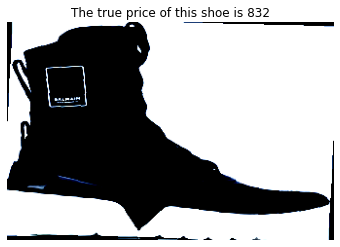

In [6]:
# load in random image from the train loader to test everything is working so far, funky colors due to normalization
loader_show_image(train_loader)

In [7]:
# load in the pretrained VGG16 model, VGG16 was observed to be the fastest produced that most accurate predictions

model = models.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
# check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# freezing model parameters, comment this out if freezing is not wanted, unfreezing may cause GPU OOM on larger models
# based on my tests on VGG16, no major benefits in prediction acurracy observed from not freezing
for param in model.parameters():
    param.requires_grad = False

# retrain the final classifier layer, fc3 outputs a single value as only one price is mapped to each image
model.classifier = nn.Sequential(OrderedDict([
                                 ('fc1', nn.Linear(25088, 4096)),
                                 ('relu1', nn.ReLU()),
                                 ('dropout1', nn.Dropout(0.5)),
                                 ('fc2', nn.Linear(4096, 4096)),
                                 ('relu2', nn.ReLU()),
                                 ('dropout2', nn.Dropout(0.5)),
                                 ('fc3', nn.Linear(4096, 1))]))

# MSE loss function as this is a regression problem
criterion = nn.MSELoss()

# using Adam for faster convergence, starting learning rate of 0.001 produced the best result
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)

# set an LR scheduler, this is not mandatory and doesn't improve prediction, just helps the model converge smoother
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.1, verbose=True)

model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
!nvidia-smi

Sun Sep 13 04:27:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.00    Driver Version: 418.87.00    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   53C    P0    27W /  70W |   1177MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

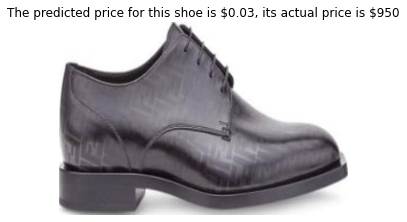

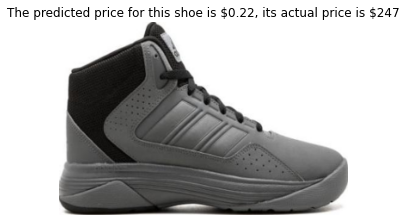

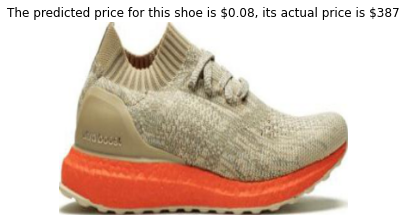

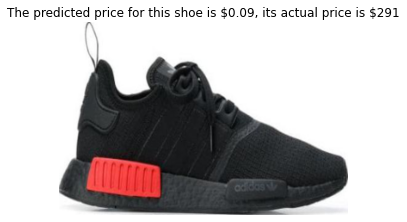

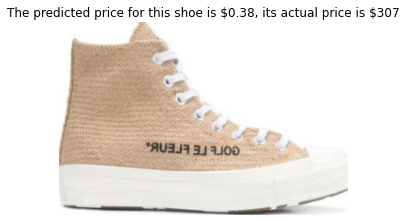

In [10]:
# A simple pass-through of a few images before training to ensure the pipeline is working
# don't worry about the low predictions as this is due to the weights being initialized

model_sample_output(test_loader, model, device)

In [11]:
# main training step, 50-60 epochs should be sufficient for convergence, this will take 2-3 hours

model, training_losses, validation_losses = train_net(75, model, train_loader, valid_loader, criterion, optimizer, scheduler, device, 'best_model_vgg_f.pth')

Epoch 1/75..Train Loss: 73898..Validation Loss: 66405..%Error: 120.09%..
Validation loss decreased (inf --> 66405.000).  Saving model ...
Epoch 2/75..Train Loss: 60441..Validation Loss: 63243..%Error: 83.09%..
Validation loss decreased (66405.000 --> 63243.000).  Saving model ...
Epoch 3/75..Train Loss: 55499..Validation Loss: 55318..%Error: 86.50%..
Validation loss decreased (63243.000 --> 55318.000).  Saving model ...
Epoch 4/75..Train Loss: 50701..Validation Loss: 59185..%Error: 114.49%..
Epoch 5/75..Train Loss: 49365..Validation Loss: 61006..%Error: 110.46%..
Epoch 6/75..Train Loss: 49467..Validation Loss: 54542..%Error: 90.75%..
Validation loss decreased (55318.000 --> 54542.000).  Saving model ...
Epoch 7/75..Train Loss: 46257..Validation Loss: 52771..%Error: 78.71%..
Validation loss decreased (54542.000 --> 52771.000).  Saving model ...
Epoch 8/75..Train Loss: 42663..Validation Loss: 49510..%Error: 95.02%..
Validation loss decreased (52771.000 --> 49510.000).  Saving model ...
E

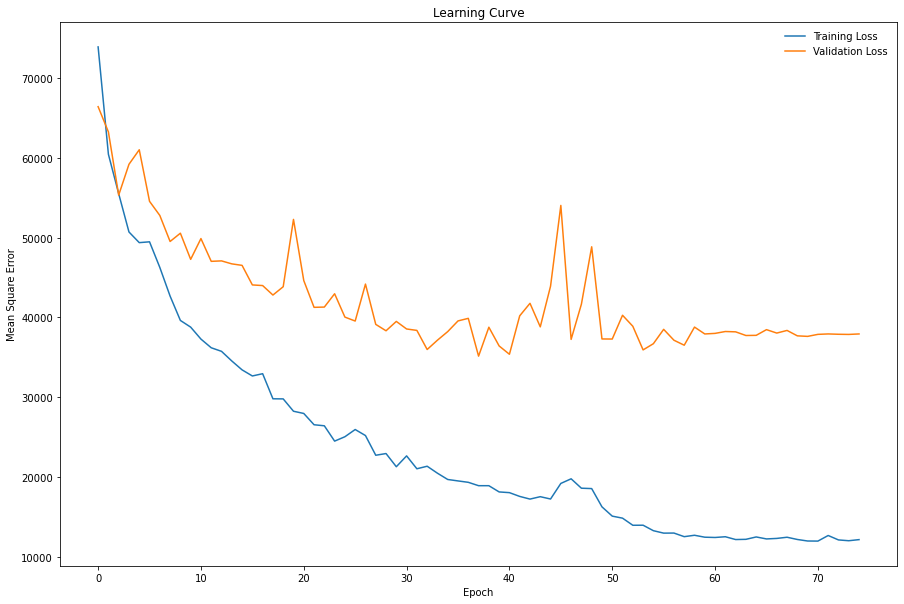

In [12]:
# plot the training curve for visualization and to check your not overfitting (if validation goes up)

plt.figure(figsize=(15, 10))
plt.plot(training_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.title('Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend(frameon=False);

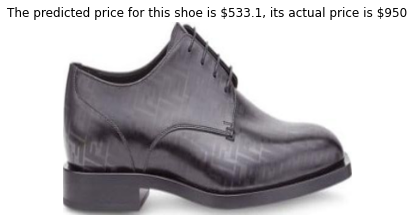

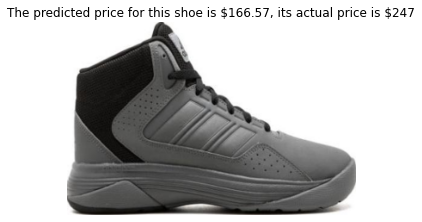

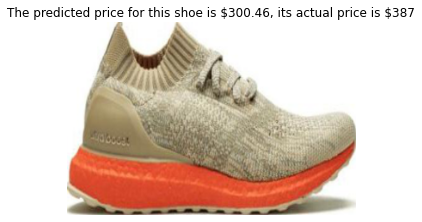

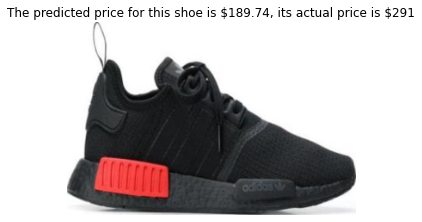

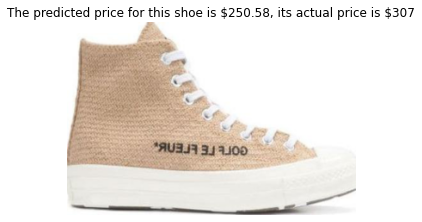

In [13]:
# pass the same set of data through the model again to see that predictions of significantly improved!

model_sample_output(test_loader, model, device)

In [14]:
# quantify the total test loss and test error achieved by your model (lower = better)

test_loss = 0
model.eval()
            
with torch.no_grad():
    for images, labels in test_loader:

        labels = labels.view(labels.size()[0], -1)

        labels = labels.type(torch.FloatTensor).to(device)
        images = images.type(torch.FloatTensor).to(device)

        predicted_labels = model.forward(images)
        batch_loss = criterion(predicted_labels, labels)
                    
        test_loss += batch_loss.item()  
                    
    error = [abs(predicted_labels[i] - labels[i]) / labels[i] for i in range(len(predicted_labels))]
    error = (sum(error) / len(predicted_labels)).cpu().numpy()[0] * 100       
    
    print(f"Test Loss: {test_loss/len(test_loader):.3f}.."
          f"Test Error: {error:.2f}..")

Test Loss: 32352.925..Test Error: 39.83..
